In [32]:
!pip install -U yellowbrick

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer

In [34]:
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [35]:
print(train.shape)
train.info()

(10000038, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [36]:
print(test.shape)
test.info()

(5000019, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [37]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [38]:
imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [39]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [40]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [41]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [42]:
metadata =pd.merge(movies,imdb,how = 'left',on = 'movieId')
genome_score_tags = pd.merge(genome_scores,genome_tags, how='left',on='tagId')

In [21]:
print(f'The metadata dataset has {metadata.shape[0]} rows/entries and {len(metadata.columns)} coulumns')
percentange=metadata.isnull().mean().round(4) * 100
count = metadata.isnull().sum()
count_percentage = pd.DataFrame({'Count':count,'Percentage': percentange,},index=metadata.columns)
count_percentage

The metadata dataset has 62423 rows/entries and 8 coulumns


,Count,Percentage
movieId,0,0.00
title,0,0.00
genres,0,0.00
title_cast,47222,75.65
director,47076,75.41
runtime,48902,78.34
budget,55140,88.33
plot_keywords,48039,76.96


In [22]:
metadata1 = metadata.copy() 

metadata1.drop(['title_cast','director','budget','plot_keywords'],
  axis='columns',inplace=True)

metadata1['runtime'].fillna((metadata1['runtime'].mean()), inplace=True)

In [23]:
df = pd.merge(metadata1,genome_score_tags,how = 'left',on = 'movieId')

In [24]:
#extracting released year
df['release_year']=df['title'].str[-5:-1] 
df['release_year'].replace('[^\(.*\)?]','', regex=True)
#spliting the genres into a list
df['genres']=df['genres'].str.split('|')

In [25]:
train_min = train[:10000]
train_df =pd.merge(df,train_min,how = 'left',on = 'movieId')
test_min = test[:10000]
test_df = pd.merge(df,test_min,how = 'left',on = 'movieId')
print(f'The train_df dataset {test_df.shape[0]} rows/entries and {len(train_df.columns)} coulumns')
print(f'The test_df dataset {train_df.shape[0]} rows/entries and {len(test_df.columns)} coulumns')

The train_df dataset 23190655 rows/entries and 11 coulumns
The test_df dataset 22765400 rows/entries and 9 coulumns


In [26]:
train_df.drop('timestamp',axis=1,inplace=True)

In [27]:
train_features = train_df.drop(['rating'],axis=1)
train_features.shape

(22765400, 9)

In [28]:
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='char')
train_transformed = tf.fit_transform(train_features).toarray()

In [19]:
scaler = StandardScaler(with_mean=False)
pca =PCA()
pipeline = make_pipeline(scaler,pca)

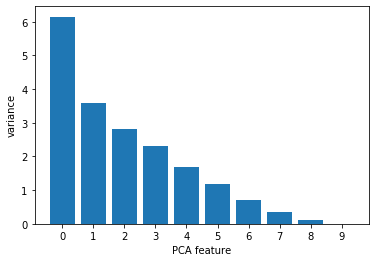

In [146]:
pipeline.fit_transform(train_transformed)
features=range(pca.n_components_)
features = features
plt.bar(features,pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [30]:
scaler = StandardScaler(with_mean=False)

scaled = scaler.fit_transform(train_transformed)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,10), metric='calinski_harabasz', timings=False
)
visualizer.fit(scaled) 
visualizer.show()

NameError: name 'KElbowVisualizer' is not defined

In [193]:
scaler = StandardScaler(with_mean=False)

scaled = scaler.fit_transform(train_transformed)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled)
    Sum_of_squared_distances.append(km.inertia_)

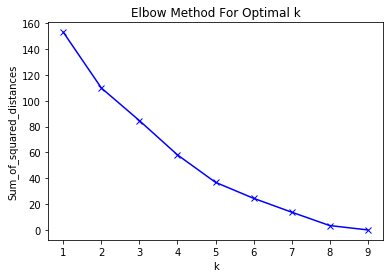

In [194]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [195]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(scaled)
df_no_labels['cluster_label'] =y_kmeans
centers = scaler.inverse_transform(km.cluster_centers_)

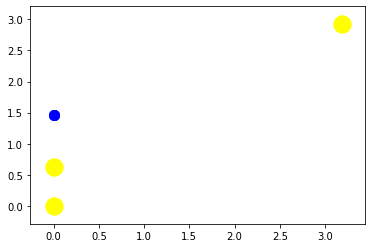

In [197]:
plt.scatter(scaled[y_kmeans == 0, 0], scaled[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(scaled[y_kmeans == 1, 0], scaled[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(scaled[y_kmeans == 2, 0], scaled[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')


plt.show()